In [1]:
# notebook for first canonical problem for multimodal optimization looking for localized extreme
# events with agent-based military simulation
# Experiment 2.1 - Deterministic literature test problem "uneven decreasing maxima" [5]
# Part 1 - benchmark approaches (MCS, QMC, NEI, TEAD, TuRBO)
#
# Author: Alex Braafladt
# Initial creation: 3/11/23
#
# Goal: Benchmark state-of-the-art Bayesian Optimization approaches (and QMC/MCS) on a multimodal
#       optimization test function focused on localized extrema
#
# Notes:
# -Using the BoTorch framework [1] and NEI from [4]
# -TEAD technique from [2]
# -TuRBO technique from [3]
#
# References:
# [1] M. Balandat et al., “BOTORCH: A framework for efficient Monte-Carlo Bayesian optimization,”
#     Adv. Neural Inf. Process. Syst., vol. 2020-Decem, no. MC, 2020.
# [2] S. Mo et al., “A Taylor Expansion-Based Adaptive Design Strategy for Global Surrogate
#     Modeling With Applications in Groundwater Modeling,” Water Resour. Res., vol. 53, no.
#     12, pp. 10802–10823, 2017, doi: 10.1002/2017WR021622.
# [3] D. Eriksson, M. Pearce, J. R. Gardner, R. Turner, and M. Poloczek, “Scalable global
#     optimization via local Bayesian optimization,” Adv. Neural Inf. Process. Syst., vol.
#     32, no. NeurIPS, 2019.
# [4] B. Letham, B. Karrer, G. Ottoni, and E. Bakshy, “Constrained Bayesian optimization with noisy
#     experiments,” Bayesian Anal., vol. 14, no. 2, pp. 495–519, 2019, doi: 10.1214/18-BA1110.
# [5] X. Li, A. Engelbrecht, and M. G. Epitropakis, “Benchmark Functions for CEC’2013 Special
#     Session and Competition on Niching Methods for Multimodal Function Optimization,” 2016.

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from extremasearch.globalmm.globalsearch import MultimodalExtremaSearch
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize

# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# setup file i/o
import os as os
import datetime as dt
# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'exp2.1_mme_nonbalanced_udm' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks\iter4_exp2
Data save directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks\iter4_exp2\output\\exp2.1_mme_nonbalanced_udm20230311164349


In [6]:
# test function
def udm_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += torch.exp(-2.0*torch.log(torch.tensor(2.0))*((x - 0.08)/0.854)**2.0) * torch.sin(5.0*torch.pi*(x**(3.0/4.0)-0.05))**6.0
    return y

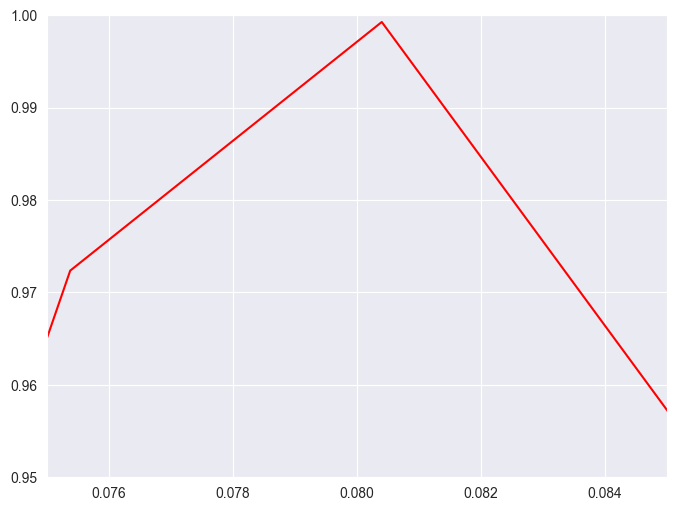

In [51]:
# plot the test function
x1 = torch.linspace(0,1.0,200)
y1 = udm_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')
ax.set_xlim([0.075, 0.085])
ax.set_ylim([0.95, 1.0])
# ax.plot([0.925, 0.925], [0, 1])
# ax.plot([0.935, 0.935], [0, 1])
plt.savefig(datasavedir + '/'+'deterministic_test_problem'+'.png')

In [14]:
# wrapper for use in optimization loop
def outcome_objective(x):
    """wrapper for the outcome objective function"""
    # return mme_torch(X).type_as(X)
    return udm_torch(x).type_as(x)

In [15]:
# utility functions

# set up the GP model for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state_dict if it is not passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

# set up the initial data set
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 1, device=device, dtype=dtype)
    exact_obj = outcome_objective(train_x)
    # train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

from botorch.optim import optimize_acqf
NUM_RESTARTS = 10
RAW_SAMPLES = 512
BATCH_SIZE = 1
bounds = torch.tensor([0.0, 1.0], device=device, dtype=dtype).unsqueeze(-1)
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = outcome_objective(new_x)
    # new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_obj = exact_obj
    return new_x, new_obj

def update_random_observation():
    """Simulates a random policy by taking the current list of best values observed
    randomly, drawing a new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(BATCH_SIZE, 1)  # drawing from random uniform
    next_random_best = outcome_objective(rand_x)
    return  rand_x, next_random_best

In [65]:
# experiment functions to calculate metrics
# metrics functions
def count_number_peaks_observed(x_obs, y_obs, num_known_peaks=5):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3, peak4, peak5 = False, False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.075 <= x <= 0.085:
            if y >= 0.95:
                peak1 = True
        elif 0.240 <= x <= 0.250:
            if y >= 0.90:
                peak2 = True
        elif 0.445 <= x <= 0.455:
            if y >= 0.73:
                peak3 = True
        elif 0.673 <= x <= 0.683:
            if y >= 0.47:
                peak4 = True
        elif 0.925 <= x <= 0.935:
            if y >= 0.238:
                peak5 = True
    num_peaks_observed = peak1 + peak2 + peak3 + peak4 + peak5
    return num_peaks_observed


def count_evaluations_for_all_peaks(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3, peak4, peak5 = False, False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.075 <= x <= 0.085:
            if y >= 0.95:
                peak1 = True
        elif 0.240 <= x <= 0.250:
            if y >= 0.90:
                peak2 = True
        elif 0.445 <= x <= 0.455:
            if y >= 0.73:
                peak3 = True
        elif 0.673 <= x <= 0.683:
            if y >= 0.47:
                peak4 = True
        elif 0.925 <= x <= 0.935:
            if y >= 0.238:
                peak5 = True
        i += 1
        if peak1 and peak2 and peak3 and peak4 and peak5:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [66]:
from extremasearch.acquisition.turbo import NewTurboState, new_update_state, generate_batch
from extremasearch.acquisition.tead import global_tead
import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from extremasearch.local.localsearch import initialize_scaled_model

N_TRIALS = 15
N_BATCH = 120 # note +10 for total iteration limit
MC_SAMPLES = 256
N_CANDIDATES = min(5000, max(2000, 200 * 1))
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all, best_observed_all_tead = [], [], []
best_observed_all_turbo = []
# {x, y} values
x_observed_all_random, x_observed_all_nei, x_observed_all_tead, x_observed_all_turbo = [], [], [], []
y_observed_all_random, y_observed_all_nei, y_observed_all_tead, y_observed_all_turbo = [], [], [], []
# mmo results
distinct_peaks_random, distinct_peaks_nei, distinct_peaks_tead, distinct_peaks_turbo = [], [], [], []
function_evals_random, function_evals_nei, function_evals_tead, function_evals_turbo = [], [], [], []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_tead = [], [], []
    best_observed_turbo = []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # tead
    # use same initial points
    train_x_tead, train_obj_tead = train_x_nei, train_obj_nei
    best_observed_value_tead = best_observed_value_nei
    mll_tead, model_tead = initialize_model(train_x_tead, train_obj_tead)
    # turbo
    train_x_turbo, train_obj_turbo = train_x_nei, train_obj_nei
    best_observed_value_turbo = best_observed_value_nei
    # turbo initialization
    state = NewTurboState(dim=1, batch_size=BATCH_SIZE, center=torch.tensor(0.5), lb=torch.tensor(0.0), ub=torch.tensor(1.0))
    state = new_update_state(state, train_x_turbo, train_obj_turbo, torch.DoubleTensor([best_observed_value_turbo]))
    tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
    mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_tead.append(best_observed_value_tead)
    best_observed_turbo.append(best_observed_value_turbo)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_tead)
        fit_gpytorch_mll(mll_turbo)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )

        # optimize the acquisition functions
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        new_x_tead = global_tead(model_tead)
        new_obj_tead = outcome_objective(new_x_tead)
        new_x_turbo = generate_batch(
            state=state,
            model=model_turbo,
            # x=train_x_turbo,
            x=state.train_x,
            # y=train_obj_turbo,
            y=state.train_y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf='ts',
            # acqf='ei',
        )
        new_obj_turbo = outcome_objective(new_x_turbo)
        # random
        new_x_random, new_obj_random = update_random_observation()

        # update training points
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_x_tead = torch.cat([train_x_tead, new_x_tead])
        train_obj_tead = torch.cat([train_obj_tead, new_obj_tead])
        train_x_turbo = torch.cat([train_x_turbo, new_x_turbo])
        train_obj_turbo = torch.cat([train_obj_turbo, new_obj_turbo])
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])

        # update trust region
        state = new_update_state(state, x_train=train_x_turbo, y_train=train_obj_turbo, y_next=new_obj_turbo)

        # update progress data
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        best_value_tead = train_obj_tead.max()
        best_observed_tead.append(best_value_tead)
        best_value_turbo = train_obj_turbo.max()
        best_observed_turbo.append(best_value_turbo)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            model_nei.state_dict(),
        )
        mll_tead, model_tead = initialize_model(
            train_x_tead,
            train_obj_tead,
            model_tead.state_dict(),
        )
        # update trust region model
        tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
        mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI, TEAD, TuRBO) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_tead:>4.2f}, {state.best_value:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_tead.append(best_observed_tead)
    best_observed_all_turbo.append(best_observed_turbo)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    x_observed_all_tead.append(train_x_tead)
    x_observed_all_turbo.append(train_x_turbo)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)
    y_observed_all_tead.append(train_obj_tead)
    y_observed_all_turbo.append(train_obj_turbo)
    # collect metrics
    distinct_peaks_random.append(count_number_peaks_observed(train_x_random, train_obj_random))
    distinct_peaks_nei.append(count_number_peaks_observed(train_x_nei, train_obj_nei))
    distinct_peaks_tead.append(count_number_peaks_observed(train_x_tead, train_obj_tead))
    distinct_peaks_turbo.append(count_number_peaks_observed(train_x_turbo, train_obj_turbo))
    function_evals_random.append(count_evaluations_for_all_peaks(train_x_random, train_obj_random))
    function_evals_nei.append(count_evaluations_for_all_peaks(train_x_nei, train_obj_nei))
    function_evals_tead.append(count_evaluations_for_all_peaks(train_x_tead, train_obj_tead))
    function_evals_turbo.append(count_evaluations_for_all_peaks(train_x_turbo, train_obj_turbo))


Trial  1 of 15 
Batch  1: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 0.96), time = 13.41.
Batch  2: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 0.96), time = 9.50.
Batch  3: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 0.96), time = 12.06.
Batch  4: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 0.96), time = 11.25.
Batch  5: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 0.99), time = 9.62.
Batch  6: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), time = 11.20.
Batch  7: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), time = 9.11.
Batch  8: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), time = 9.47.
Batch  9: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), time = 8.95.
Batch 10: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), time = 9.05.
Batch 11: best_value (random, qNEI, TEAD, TuRBO) = (0.96, 0.96, 0.96, 1.00), ti

In [67]:
# abbreviated QMC loop with Sobol sequences
from torch.quasirandom import SobolEngine

best_observed_all_sobol = []
x_observed_all_sobol, y_observed_all_sobol = [], []
distinct_peaks_sobol = []
function_evals_sobol = []
for trial in range(1, N_TRIALS + 1):
    print(f"\nSobol Trial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_sobol = []
    # get sobol random samples for the trial
    X_Sobol = SobolEngine(1, scramble=True).draw(N_BATCH + 10).to(dtype=dtype, device=device)
    Y_Sobol = torch.tensor([outcome_objective(x) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(-1)
    curMax = torch.max(Y_Sobol[:10])
    for y_val in Y_Sobol[10:]:
        curMax = torch.max(curMax, y_val)
        best_observed_sobol.append(curMax.squeeze())
    best_observed_all_sobol.append(best_observed_sobol)
    x_observed_all_sobol.append(X_Sobol)
    y_observed_all_sobol.append(Y_Sobol)
    distinct_peaks_sobol.append(count_number_peaks_observed(X_Sobol, Y_Sobol))
    function_evals_sobol.append(count_evaluations_for_all_peaks(X_Sobol, Y_Sobol))


Sobol Trial  1 of 15 
Sobol Trial  2 of 15 
Sobol Trial  3 of 15 
Sobol Trial  4 of 15 
Sobol Trial  5 of 15 
Sobol Trial  6 of 15 
Sobol Trial  7 of 15 
Sobol Trial  8 of 15 
Sobol Trial  9 of 15 
Sobol Trial 10 of 15 
Sobol Trial 11 of 15 
Sobol Trial 12 of 15 
Sobol Trial 13 of 15 
Sobol Trial 14 of 15 
Sobol Trial 15 of 15 

In [68]:
# collect output data
# calculate summary metrics
# peak ratio
num_known_peaks = 5
peak_ratio_random = sum(distinct_peaks_random) / (num_known_peaks * N_TRIALS)
peak_ratio_nei = sum(distinct_peaks_nei) / (num_known_peaks * N_TRIALS)
peak_ratio_tead = sum(distinct_peaks_tead) / (num_known_peaks * N_TRIALS)
peak_ratio_turbo = sum(distinct_peaks_turbo) / (num_known_peaks * N_TRIALS)
peak_ratio_sobol = sum(distinct_peaks_sobol) / (num_known_peaks * N_TRIALS)
print(f"Peak ratio: Random {peak_ratio_random:>4.2f}, NEI {peak_ratio_nei:>4.2f}, TEAD {peak_ratio_tead:>4.2f}, TuRBO {peak_ratio_turbo:>4.2f}, QMC {peak_ratio_sobol:>4.2f} ")
# success rate
num_successes_random = 0
num_successes_nei = 0
num_successes_tead = 0
num_successes_turbo = 0
num_successes_sobol = 0
for i in range(N_TRIALS):
    if distinct_peaks_random[i] == num_known_peaks:
        num_successes_random += 1
    if distinct_peaks_nei[i] == num_known_peaks:
        num_successes_nei += 1
    if distinct_peaks_tead[i] == num_known_peaks:
        num_successes_tead += 1
    if distinct_peaks_turbo[i] == num_known_peaks:
        num_successes_turbo += 1
    if distinct_peaks_sobol[i] == num_known_peaks:
        num_successes_sobol += 1
success_ratio_random = num_successes_random / N_TRIALS
success_ratio_nei = num_successes_nei / N_TRIALS
success_ratio_tead = num_successes_tead / N_TRIALS
success_ratio_turbo = num_successes_turbo / N_TRIALS
success_ratio_sobol = num_successes_sobol / N_TRIALS
print(f"Success ratio: Random {success_ratio_random:>4.2f}, NEI {success_ratio_nei:>4.2f}, TEAD {success_ratio_tead:>4.2f}, TuRBO {success_ratio_turbo:>4.2f}, Sobol {success_ratio_sobol:>4.2f}")
# function evaluations
fe_random = sum(function_evals_random)/N_TRIALS
fe_nei = sum(function_evals_nei)/N_TRIALS
fe_tead = sum(function_evals_tead)/N_TRIALS
fe_turbo = sum(function_evals_turbo)/N_TRIALS
fe_sobol = sum(function_evals_sobol)/N_TRIALS
print(f"Average function evaluations: Random {fe_random}, NEI {fe_nei}, TEAD {fe_tead}, TuRBO {fe_turbo}, Sobol {fe_sobol}")
# save data to file for potential future use
methods_list = ['MCS', 'NEI', 'TEAD', 'TuRBO', 'QMC']
pr_list = [peak_ratio_random, peak_ratio_nei, peak_ratio_tead, peak_ratio_turbo, peak_ratio_sobol]
sr_list = [success_ratio_random, success_ratio_nei, success_ratio_tead, success_ratio_turbo, success_ratio_sobol]
fe_list = [function_evals_random, function_evals_nei, function_evals_tead, function_evals_turbo, function_evals_sobol]
import pickle
with open(datasavedir + '/' + 'mme_metrics.pkl', 'wb') as f:
    pickle.dump([methods_list, pr_list, sr_list, fe_list], f)
# to retrieve
# with open(datasavedir + '/' + 'mme_metrics.pkl') as f:
#     methods_list, pr_list, sr_list, fe_list = pickle.load(f)

Peak ratio: Random 0.69, NEI 0.88, TEAD 0.96, TuRBO 0.39, QMC 0.96 
Success ratio: Random 0.07, NEI 0.47, TEAD 0.80, TuRBO 0.00, Sobol 0.80
Average function evaluations: Random 127.53333333333333, NEI 114.33333333333333, TEAD 95.0, TuRBO 130.0, Sobol 102.8


In [69]:
# setting up data for plotting
y_tead = np.asarray(best_observed_all_tead)
y_sobol = np.asarray(best_observed_all_sobol)

fit_gpytorch_mll(mll_nei)
fit_gpytorch_mll(mll_tead)
fit_gpytorch_mll(mll_turbo)
None

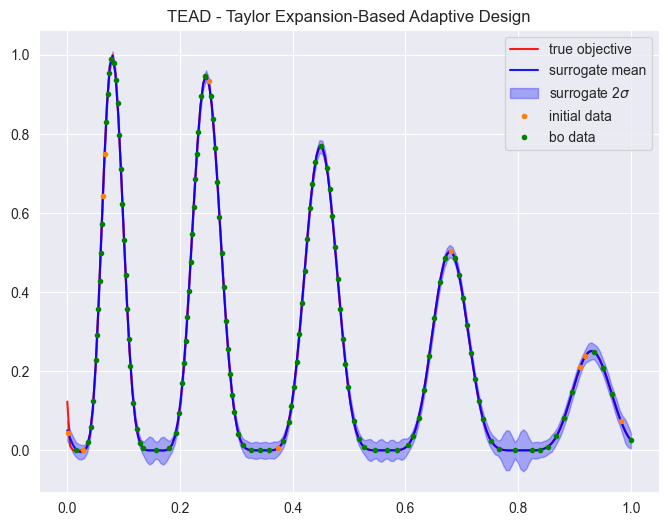

In [70]:
# plot the results for tead
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
# final model
mean_test = model_tead.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_tead.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_tead.numpy()[0:10], train_obj_tead[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_tead.numpy()[10:], train_obj_tead[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
ax.set_title('TEAD - Taylor Expansion-Based Adaptive Design')
plt.savefig(datasavedir + '/'+'test_final_state'+'.png')

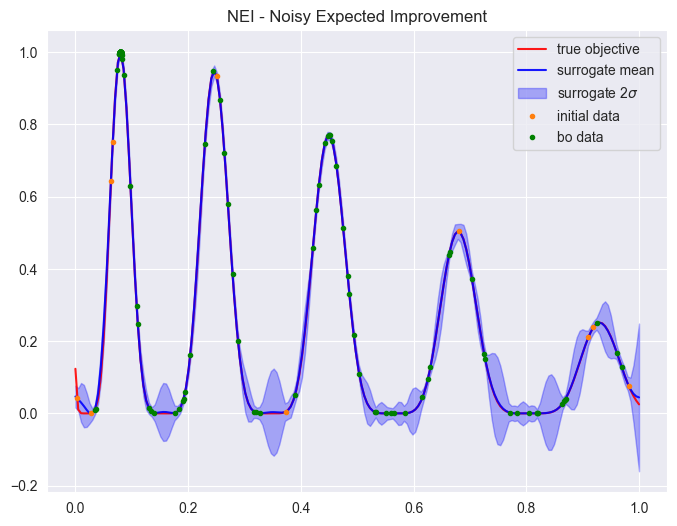

In [71]:
# plot the results for nei
x_test = torch.linspace(0, 1, 200)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
# true objective
ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
# final model
mean_test = model_nei.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_nei.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0 * sd_test
lower_test = mean_test - 2.0 * sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3,
                label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_nei.numpy()[0:10], train_obj_nei[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_nei.numpy()[10:], train_obj_nei[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
ax.set_title('NEI - Noisy Expected Improvement')
plt.savefig(datasavedir + '/'+'nei_final_state'+'.png')

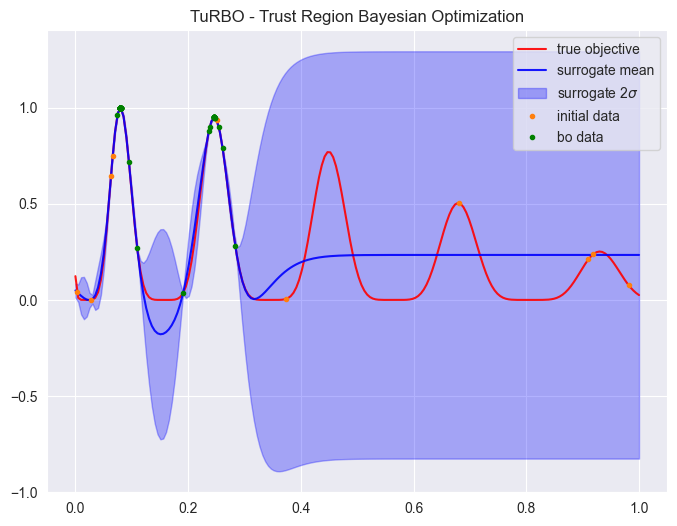

In [72]:
# plot the results for turbo
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
# final model
mean_test = model_turbo.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_turbo.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_turbo.numpy()[0:10], train_obj_turbo[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_turbo.numpy()[10:], train_obj_turbo[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
ax.set_title('TuRBO - Trust Region Bayesian Optimization')
plt.savefig(datasavedir + '/'+'turbo_final_state'+'.png')

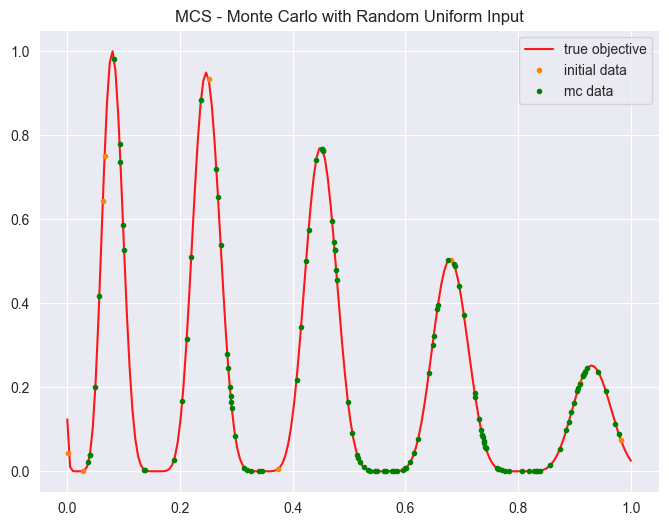

In [73]:
# plot the results for random
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
# training points
ax.plot(train_x_random.numpy()[0:10], train_obj_random[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_random.numpy()[10:], train_obj_random[10:].numpy(), '.', color='g', label='mc data')
ax.legend()
ax.set_title('MCS - Monte Carlo with Random Uniform Input')
plt.savefig(datasavedir + '/'+'mcs_final_state'+'.png')

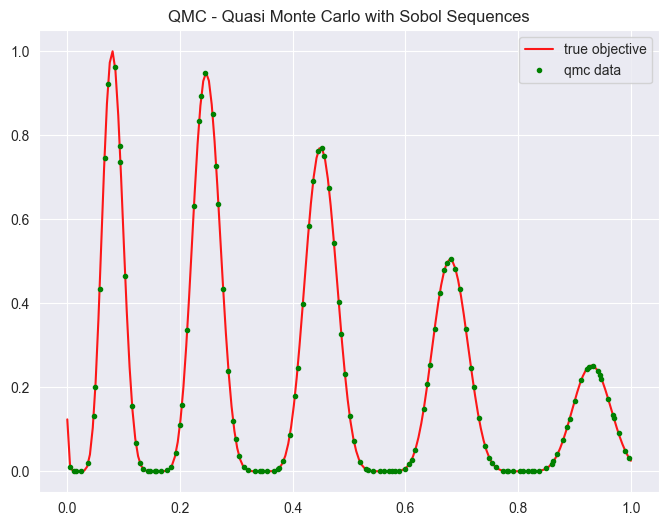

In [74]:
# plot the results for qmc
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
# training points
ax.plot(X_Sobol.numpy(), Y_Sobol.numpy(), '.', color='g', label='qmc data')
ax.legend()
ax.set_title('QMC - Quasi Monte Carlo with Sobol Sequences')
plt.savefig(datasavedir + '/'+'qmc_final_state'+'.png')